In [126]:
import os
import csv
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [4]:
OUTPUT_DIR = os.path.join('..', '..', 'processed')

In [161]:
def get_entity_type(entity_tag):
    if entity_tag == 'O':# or entity_tag.startswith('I-'):
        return None

    splits = entity_tag.split('-')
    return (splits[0], splits[-1])

def calculate_dataset_statistics():
    entity_types_without_duplications = Counter()
    entity_types = Counter()
    sub_entity_types = {
        'gender': Counter(),
        'legal-status': Counter(),
        'role': Counter()
    }

    sub_entities_by_annotator = {}
    person_sub_entities = Counter()

    duplicated_words = []
    total_words = 0
    total_tags = 0
    current_annotator = ''
    current_document = ''

    entities_lengths = {}
    current_lengths = Counter()

    output_file = os.path.join(OUTPUT_DIR, 'train-nl.tsv')
    with open(output_file, 'r', encoding='utf-8', newline='') as file_handler:
        csv_reader = csv.DictReader(file_handler, fieldnames=['TOKEN', 'NE-MAIN', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'MISC'], delimiter='\t')
        for i, row in enumerate(csv_reader):
            pos_type = None
            if i == 0:
                continue

            # skip all empty and commented lines
            if row['NE-MAIN'] == '':
                if row['TOKEN'].startswith('# annotator'):
                    current_annotator = row['TOKEN'].split('# annotator = ')[-1]

                if row['TOKEN'].startswith('# document'):
                    current_document = row['TOKEN'].split('# document = ')[-1]
                continue

            total_words += 1
            main_entity_types = [get_entity_type(x) for x in row['NE-MAIN'].split(',')]
            for main_entity_type_pair in main_entity_types:
                if main_entity_type_pair is None:
                    continue

                (pos_type, main_entity_type) = main_entity_type_pair

                if pos_type != 'I':
                    total_tags += 1
                    entity_types[main_entity_type] += 1

                sub_entity_count = 0

                if main_entity_type in current_lengths.keys():
                    if pos_type == 'B':
                        if main_entity_type not in entities_lengths.keys():
                            entities_lengths[main_entity_type] = []

                        entities_lengths[main_entity_type].append(current_lengths[main_entity_type])
                        current_lengths[main_entity_type] = 1
                    else:
                        current_lengths[main_entity_type] += 1
                else:
                    current_lengths[main_entity_type] = 1

            if pos_type is None or pos_type == 'I':
                continue

            gender = get_entity_type(row['NE-PER-GENDER'])
            if gender is not None:
                sub_entity_types['gender'][gender] += 1
                sub_entity_count += 1

            legal_status = get_entity_type(row['NE-PER-LEGAL-STATUS'])
            if legal_status is not None:
                sub_entity_types['legal-status'][legal_status] += 1
                sub_entity_count += 1

            role = get_entity_type(row['NE-PER-ROLE'])
            if role is not None:
                sub_entity_types['role'][role] += 1
                sub_entity_count += 1

            if 'Person' in [x[1] for x in main_entity_types if x is not None]:
                person_sub_entities[sub_entity_count] += 1

                if current_annotator not in sub_entities_by_annotator.keys():
                    sub_entities_by_annotator[current_annotator] = Counter()

                sub_entities_by_annotator[current_annotator][sub_entity_count] += 1

        for entity_type, current_length in current_lengths.items():
            entities_lengths[entity_type].append(current_length)

    return entity_types_without_duplications, entity_types, sub_entity_types, duplicated_words, total_words, total_tags, person_sub_entities, sub_entities_by_annotator, entities_lengths

In [162]:
entity_types_without_duplications, entity_types, sub_entity_types, duplicated_words, total_words, total_tags, person_sub_entities, sub_entities_by_annotator, entities_lengths = calculate_dataset_statistics()

Johan
Roos
218
# document_path = ..\..\2021-national-archives-data-annotation-project\data\Roos\6848\NL-HaNA_1.04.02_6848_0127.txt


Exception: 

In [105]:
print(f'Total words: {total_words}')
print(f'Total tags: {total_tags}')
# print(f'Total duplications: {len(duplicated_words)}')
# print(f'Avg duplications: {np.mean(duplicated_words)}')

Total words: 315885
Total tags: 20111


In [106]:
def plot_pie_entity_types(entity_types, title, ax, explode=None):
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = list(entity_types.keys())
        sizes = list(entity_types.values())

        ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode,
                shadow=True, startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        ax.set_title(title, fontweight='bold')

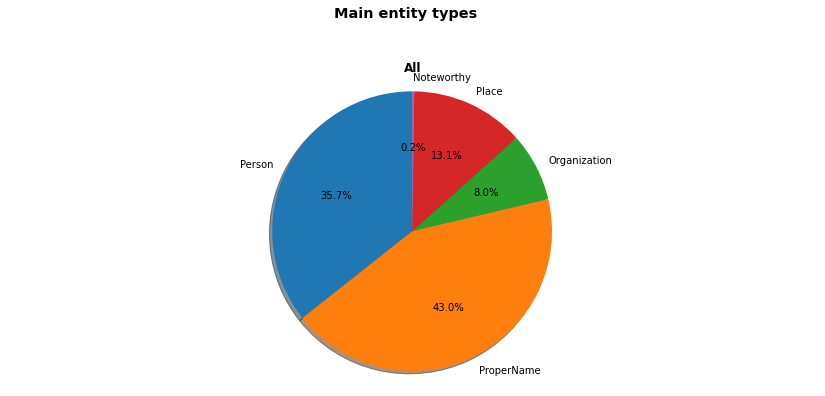

In [107]:
width = 6
fig, ax1 = plt.subplots(1, 1, figsize=(width*2,width))
fig.tight_layout(rect=[0, 0.03, 1, 0.85])

fig.suptitle('Main entity types', fontweight='bold', fontsize='x-large')

plot_pie_entity_types(entity_types, 'All', ax1)
# plot_pie_entity_types(entity_types_without_duplications, 'Without duplications', ax2)

plt.show()

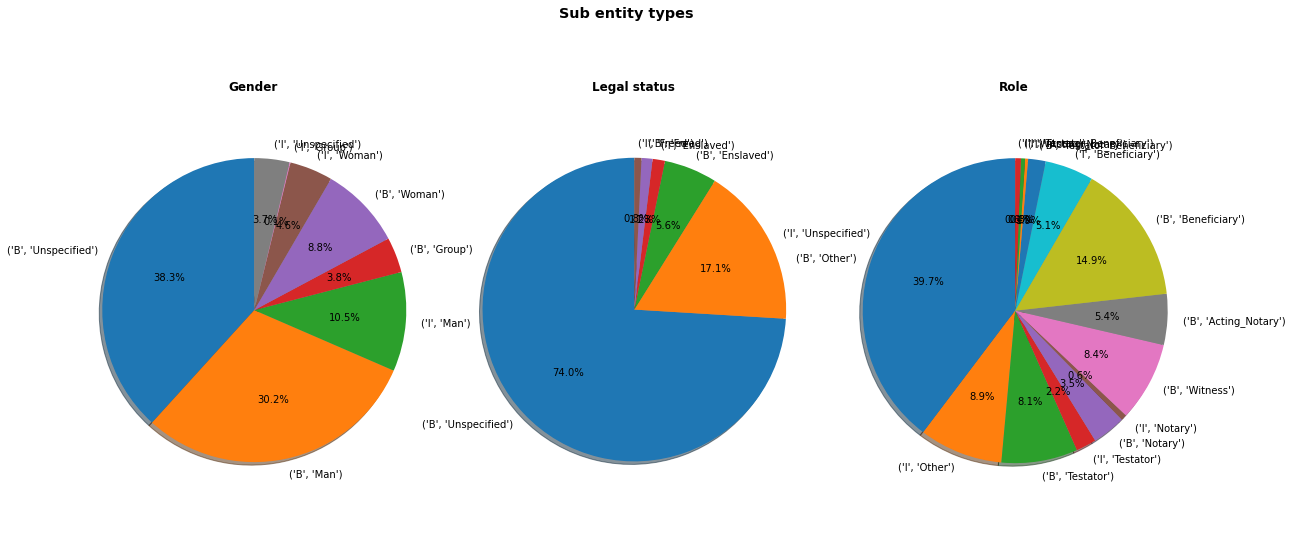

In [108]:
width = 8
fig, axes = plt.subplots(1, 3, figsize=(width*2,width))
fig.tight_layout(rect=[0, 0.03, 1, 0.85])

fig.suptitle('Sub entity types', fontweight='bold', fontsize='x-large')

for (type, values), ax in zip(sub_entity_types.items(), axes):
    user_friendly_type = type.replace('-', ' ').capitalize()
    plot_pie_entity_types(values, user_friendly_type, ax)

plt.show()

In [109]:
def print_sub_entity_counter(counter):
    total_elements = sum(list(counter.values()))
    percentages = {k: round((v / float(total_elements)) * 100, 2) for k, v in counter.items()}
    keys = sorted(list(counter.keys()))

    print('Person sub entities:')
    for key in keys:
        print(f'{key} -- Total: {counter[key]:5d}, Percentage: {percentages[key]:5.2f}%')

In [110]:
print_sub_entity_counter(person_sub_entities)

Person sub entities:
0 -- Total:     4, Percentage:  0.05%
1 -- Total:     8, Percentage:  0.09%
2 -- Total:   421, Percentage:  4.78%
3 -- Total:  8369, Percentage: 95.08%


In [111]:
for annotator, sub_entitities_counter in sub_entities_by_annotator.items():
    print(f'\n{annotator}: ')
    print_sub_entity_counter(sub_entitities_counter)


Bert: 
Person sub entities:
2 -- Total:   133, Percentage: 26.87%
3 -- Total:   362, Percentage: 73.13%

Emma: 
Person sub entities:
2 -- Total:    13, Percentage:  0.85%
3 -- Total:  1512, Percentage: 99.15%

Jonas: 
Person sub entities:
0 -- Total:     1, Percentage:  0.07%
1 -- Total:     7, Percentage:  0.52%
2 -- Total:   264, Percentage: 19.78%
3 -- Total:  1063, Percentage: 79.63%

Roos: 
Person sub entities:
0 -- Total:     1, Percentage:  0.04%
2 -- Total:     6, Percentage:  0.25%
3 -- Total:  2398, Percentage: 99.71%

Silja: 
Person sub entities:
0 -- Total:     2, Percentage:  0.13%
2 -- Total:     4, Percentage:  0.26%
3 -- Total:  1539, Percentage: 99.61%

Yolien: 
Person sub entities:
1 -- Total:     1, Percentage:  0.07%
2 -- Total:     1, Percentage:  0.07%
3 -- Total:  1495, Percentage: 99.87%


In [156]:
for key, values in entities_lengths.items():
    counter = Counter(values)
    print(f'{key}:')
    
    for k, v in sorted(counter.items()):
        print(f'  - length: {k:3d}, occurrences: {v:4d}')

ProperName:
  - length:   1, occurrences: 2635
  - length:   2, occurrences: 2668
  - length:   3, occurrences: 2100
  - length:   4, occurrences:  750
  - length:   5, occurrences:  232
  - length:   6, occurrences:  109
  - length:   7, occurrences:   50
  - length:   8, occurrences:   46
  - length:   9, occurrences:   27
  - length:  10, occurrences:   14
  - length:  11, occurrences:    6
  - length:  12, occurrences:    6
  - length:  13, occurrences:    3
  - length:  14, occurrences:    1
  - length:  16, occurrences:    1
  - length:  17, occurrences:    1
  - length:  19, occurrences:    1
  - length:  22, occurrences:    1
  - length:  24, occurrences:    2
  - length:  27, occurrences:    1
Person:
  - length:   1, occurrences: 1015
  - length:   2, occurrences: 2033
  - length:   3, occurrences: 2010
  - length:   4, occurrences:  998
  - length:   5, occurrences:  547
  - length:   6, occurrences:  260
  - length:   7, occurrences:  129
  - length:   8, occurrences:   74


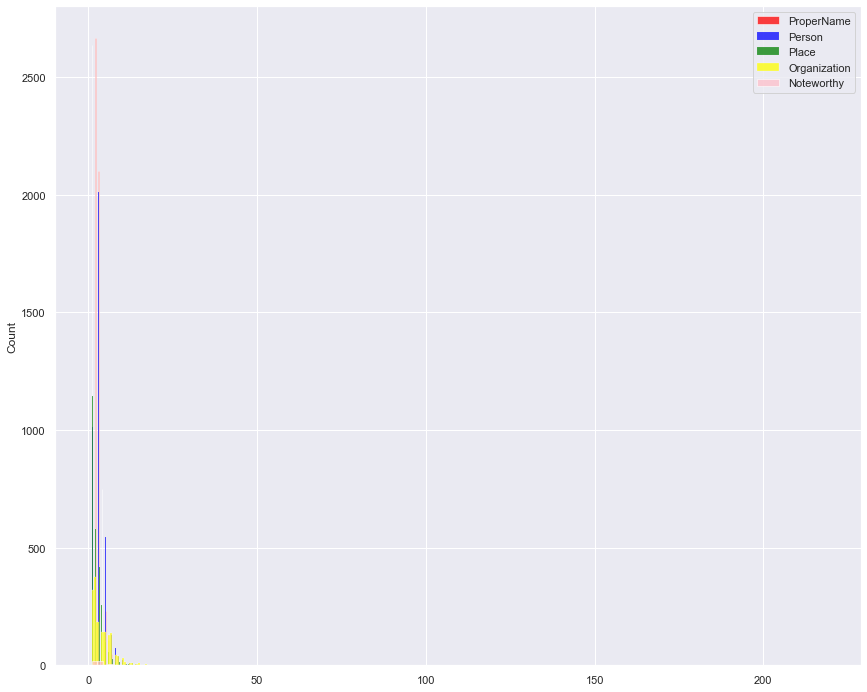

In [149]:
width = 12
fig, ax1 = plt.subplots(1, 1, figsize=(width,width))
fig.tight_layout(rect=[0, 0.03, 1, 0.85])

colors=['red','blue','green','yellow','pink']
for i, (key, values) in enumerate(entities_lengths.items()):
    sns.histplot(values, label=key, ax=ax1, color=colors[i])

plt.legend()